# Импорти, глобални параметри, функции

In [1]:
from dask import dataframe as dd
from datetime import datetime
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import pandas_alive
import moviepy.editor as mp
import os

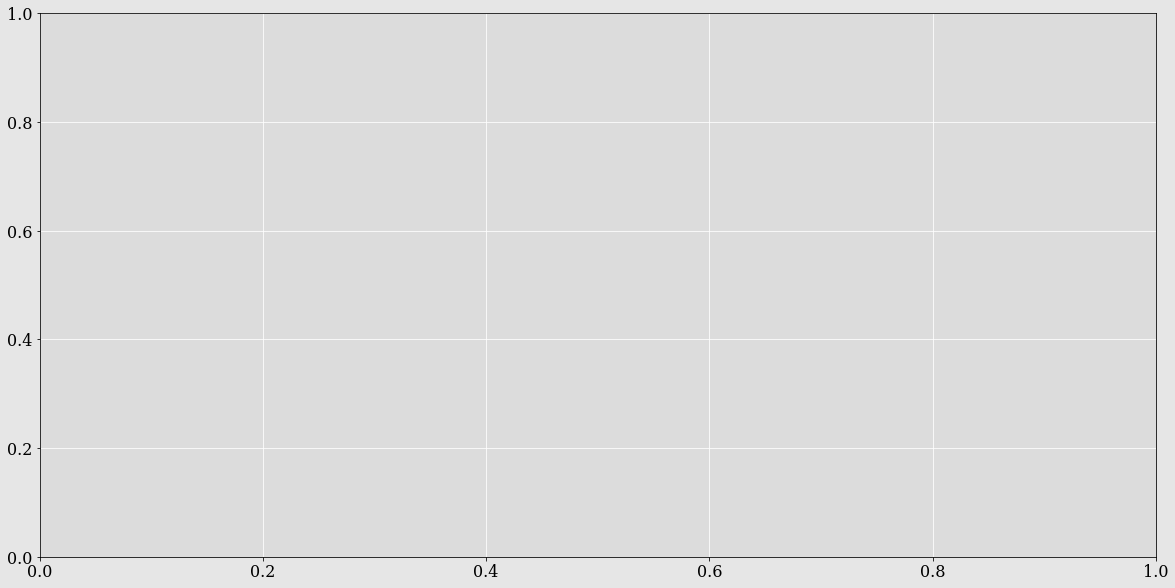

In [3]:
plt.style.use('style.mplstyle')

fig = plt.figure()
ax = plt.axes()

In [4]:
SAVE_FILES = True

if not os.path.exists('output'):
    os.mkdir('output')

if not os.path.exists('output\\temp'):
    os.mkdir('output\\temp')

In [5]:
def parse_timestamp(timestamp, date_format):
    timestamp /= 1000
    timestamp = int(timestamp)
    timestamp += 1648806250

    dt = datetime.fromtimestamp(timestamp).strftime(date_format)
    dt = datetime.strptime(dt, date_format)

    return dt

In [6]:
def parse_color(pixel_color):

    colors_dict = {
        '#000000': 0,
        '#00756F': 1,
        '#009EAA': 2,
        '#00A368': 3,
        '#00CC78': 4,
        '#00CCC0': 5,
        '#2450A4': 6,
        '#3690EA': 7,
        '#493AC1': 8,
        '#515252': 9,
        '#51E9F4': 10,
        '#6A5CFF': 11,
        '#6D001A': 12,
        '#6D482F': 13,
        '#7EED56': 14,
        '#811E9F': 15,
        '#898D90': 16,
        '#94B3FF': 17,
        '#9C6926': 18,
        '#B44AC0': 19,
        '#BE0039': 20,
        '#D4D7D9': 21,
        '#DE107F': 22,
        '#E4ABFF': 23,
        '#FF3881': 24,
        '#FF4500': 25,
        '#FF99AA': 26,
        '#FFA800': 27,
        '#FFB470': 28,
        '#FFD635': 29,
        '#FFF8B8': 30,
        '#FFFFFF': 31,
    }

    return [k for k, v in colors_dict.items() if v == pixel_color][0]

In [7]:
def millions(x, pos):
    return '%1.1f' % (x * 1e-6)

formatter = FuncFormatter(millions)

# Импортиране на файлове

In [10]:
ddf_users = dd.read_parquet('data\\data_users', engine='pyarrow')

ddf_users.head()

,user_id
0,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...
1,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...
2,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...
3,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...
4,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...


In [9]:
ddf_main = dd.read_parquet('data\\data_core', engine='pyarrow')

ddf_main['pixel_color'] = ddf_main['pixel_color'].map(parse_color)

ddf_main.head()

,timestamp,pixel_color,coordinate
97731,0,#7EED56,"42,42"
97732,12356,#00A368,"999,999"
97733,16311,#3690EA,"44,42"
97734,21388,#D4D7D9,"2,2"
97735,34094,#3690EA,"23,23"


In [10]:
ddf_pivoted = dd.read_parquet('data\\data_hourly-colors-count', engine='pyarrow')

ddf_pivoted.head()

pixel_color,#000000,#00A368,#2450A4,#3690EA,#51E9F4,#7EED56,#811E9F,#898D90,#9C6926,#B44AC0,...,#BE0039,#FF3881,#00CCC0,#515252,#6D001A,#94B3FF,#DE107F,#E4ABFF,#FFB470,#FFF8B8
datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-01 12:00:00,0,2,3,2,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-04-01 13:00:00,117511,21775,83172,15056,24328,21971,19421,7081,6169,5815,...,0,0,0,0,0,0,0,0,0,0
2022-04-01 14:00:00,198737,33085,115221,20169,38124,30806,26811,12597,9609,7658,...,0,0,0,0,0,0,0,0,0,0
2022-04-01 15:00:00,242980,35452,98686,25440,42816,33479,27869,17086,12235,10745,...,0,0,0,0,0,0,0,0,0,0
2022-04-01 16:00:00,246588,40658,99270,29857,49147,37166,32077,20787,11657,9305,...,0,0,0,0,0,0,0,0,0,0


In [13]:
ddf_datecount = dd.read_parquet('data\\data_hourly-pixels', engine='pyarrow')

ddf_datecount.head()

,datetime,num_pixels
0,2022-04-01 12:00:00,19
1,2022-04-01 13:00:00,548836
2,2022-04-01 14:00:00,867847
3,2022-04-01 15:00:00,996924
4,2022-04-01 16:00:00,1070919


# Статични диаграми

### Стълбовидна диаграма, представяща 20-те най-активни потребители

In [15]:
all_users = ddf_users.user_id.value_counts().compute().reset_index(name='num_placed_pixels')
most_active_users = all_users.head(20).set_index('index')

most_active_users.head()

,num_placed_pixels
index,
kgZoJz//JpfXgowLxOhcQlFYOCm8m6upa6Rpltcc63K6Cz0vEWJF/RYmlsaXsIQEbXrwz+Il3BkD8XZVx7YMLQ==,795
JMlte6XKe+nnFvxcjT0hHDYYNgiDXZVOkhr6KT60EtJAGaezxc4e/eah6JzTReWNdTH4fLueQ20A4drmfqbqsw==,781
LNbGhj45pAeCvBYQF1dPvwx1zVfVTy8AdRxTSHi0pR9YeabE3sAd3Rz1MbLFT5k14j0+grrVgqYO1/6BA/jBfQ==,777
8USqGo14WuZQLG7PSAwqfFwICkU0G4VyHZTuV8D1QSbQHE5GFdC2mIK/pMEC/qF1FQH912SDim3ptEFkYPrYMQ==,767
K54RRTUCFuOU55RzSTkjo/ftbJqVi9miyt52YV6NlENRfUyJTPJKBC47N/s2eh4iNdAKMKxa3gvL2XFqCc9AqQ==,767


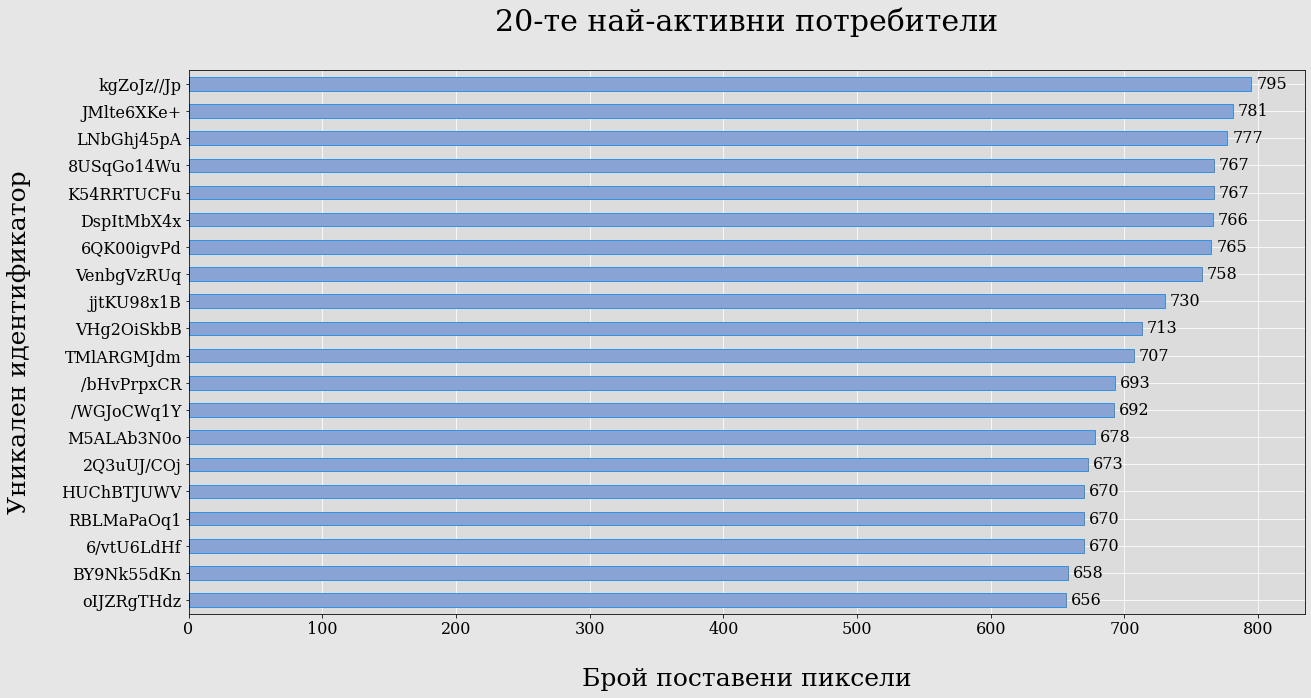

In [16]:
plot = most_active_users.plot(kind='barh', edgecolor='#3193E4')
plot.set_title('20-те най-активни потребители')
plot.set_xlabel('Брой поставени пиксели')
plot.set_ylabel('Уникален идентификатор')

y_tick_labels = []
for label in plot.get_yticklabels():
    y_tick_labels.append(label.get_text()[0:10])

plot.set_yticklabels(y_tick_labels)

bar_labels = plot.containers[0]
plot.axes.bar_label(bar_labels, padding=5, fontsize=16)

plot.invert_yaxis()

plot.get_legend().remove()

In [17]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\plot_users-{now}.png')

### Разпръсната диаграма, представяща броя потребители според това колко пиксели са поставили

In [18]:
num_active_users = all_users.num_placed_pixels.value_counts().reset_index(name='users')

num_active_users.head()

,index,users
0,1,2340498
1,2,1175052
2,3,768335
3,4,572021
4,5,460215


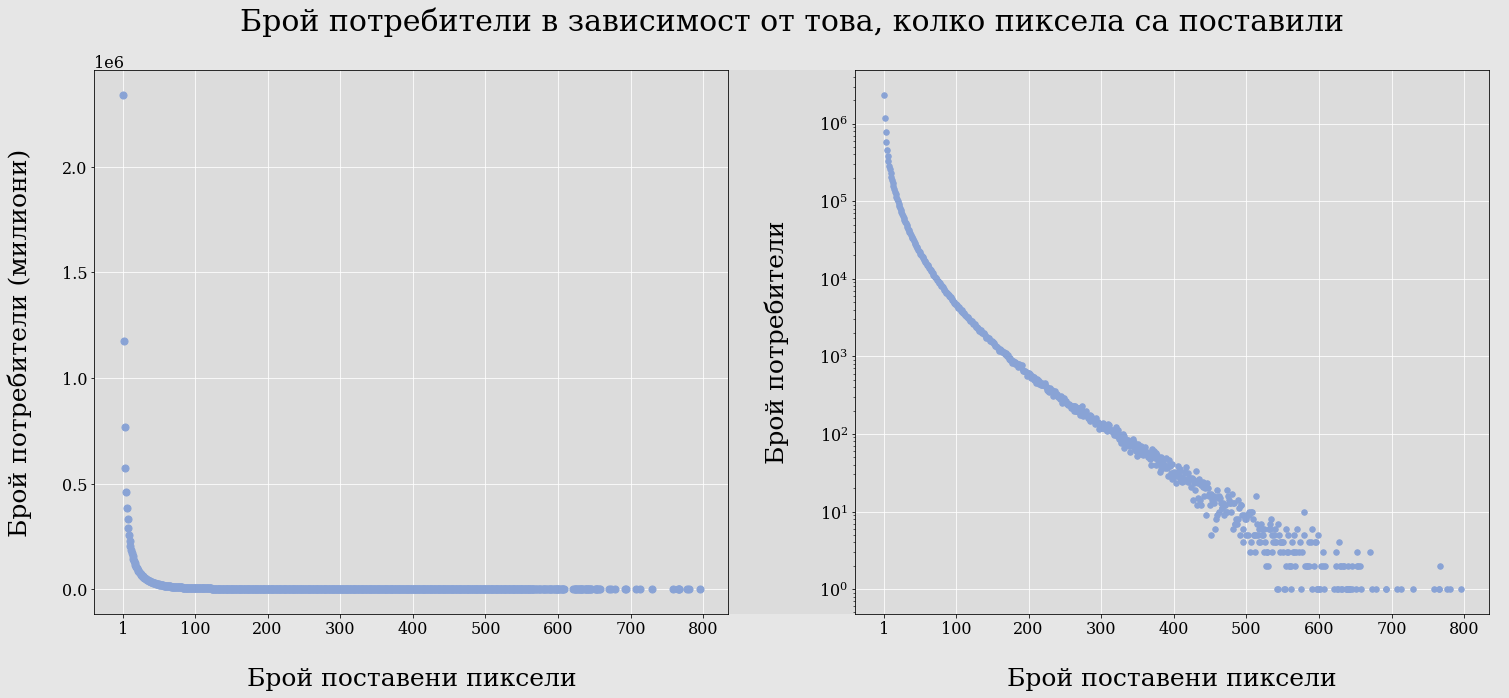

In [19]:
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111)    
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='#E6E6E6', top=False, bottom=False, left=False, right=False)
ax.grid(False)

ax.set_title('Брой потребители в зависимост от това, колко пиксела са поставили')

num_active_users.plot(x=0, y=1, kind='scatter', zorder=3, s=50, ax=ax1)

ax1.set_xlabel('Брой поставени пиксели')
ax1.set_ylabel('Брой потребители (милиони)')
ax1.set_xticks([1,100,200,300,400,500,600,700,800])

num_active_users.plot(x=0, y=1, kind='scatter', zorder=3, s=30, ax=ax2)

ax2.set_xlabel('Брой поставени пиксели')
ax2.set_ylabel('Брой потребители')
ax2.set_yscale('log')
ax2.set_xticks([1,100,200,300,400,500,600,700,800])

In [20]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig.savefig(f'output\\plot_activity-{now}.png')

### Намиране на броя потребители, участвали в експеримента

In [21]:
unique_users = all_users['index'].count()

print(f'Брой потребители, участвали в експеримента: {unique_users}')

Брой потребители, участвали в експеримента: 10381163


### Диаграма, представяща броя поставени пиксели от всеки цвят

In [22]:
ddf_colors = ddf_main.copy()
ddf_colors = ddf_colors.drop(['timestamp', 'coordinate'], axis=1)

ddf_colors.head()

,pixel_color
97731,#7EED56
97732,#00A368
97733,#3690EA
97734,#D4D7D9
97735,#3690EA


In [23]:
most_used_colors = ddf_colors.pixel_color.value_counts().compute()

most_used_colors.head()

#000000    33707371
#FFFFFF    32251013
#FF4500    14411389
#2450A4     9989854
#FFD635     8519392
Name: pixel_color, dtype: int64

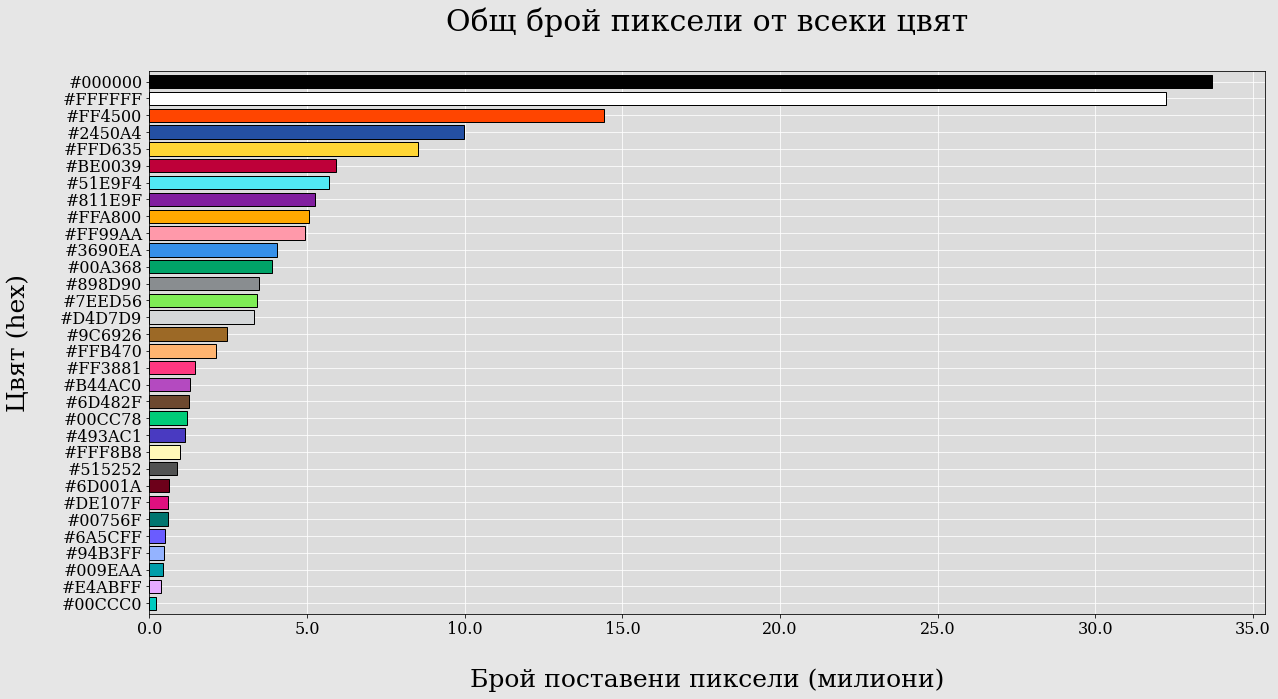

In [24]:
color_bars = []
for color_num in most_used_colors.iteritems():
    color_bars.append(color_num[0])

plot = most_used_colors.plot(kind='barh', color=color_bars, edgecolor='black', zorder=3, width=0.8)

plot.set_title('Общ брой пиксели от всеки цвят')
plot.set_xlabel('Брой поставени пиксели (милиони)')
plot.set_ylabel('Цвят (hex)')

plot.set_yticklabels(color_bars)
plot.xaxis.set_major_formatter(formatter)
    
plot.invert_yaxis()

In [25]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\plot_colors-{now}.png')

### Диаграма, представяща броя поставени пиксели от всеки цвят (с 5-те най-популярни изключени)

In [26]:
least_used_colors = most_used_colors.drop(['#000000', '#FFFFFF', '#FF4500', '#2450A4', '#FFD635'])

least_used_colors.head()

#BE0039    5911641
#51E9F4    5700301
#811E9F    5245484
#FFA800    5059970
#FF99AA    4917801
Name: pixel_color, dtype: int64

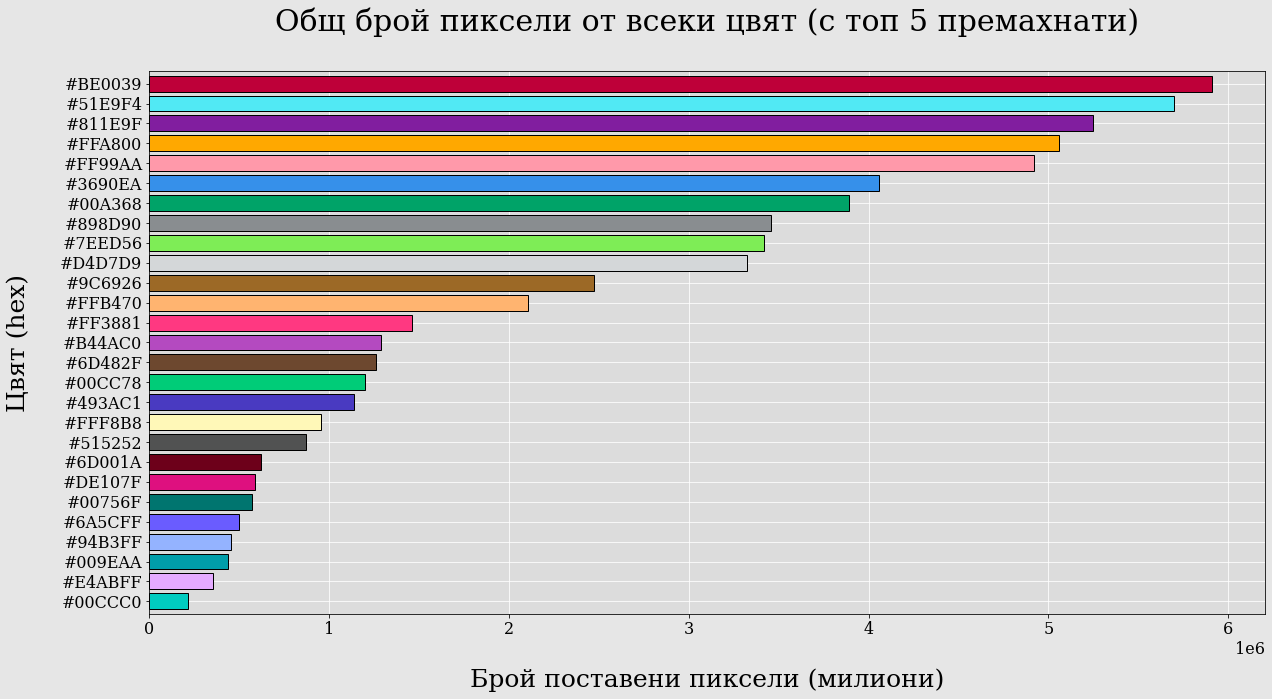

In [27]:
color_bars = []
for color_num in least_used_colors.iteritems():
    color_bars.append(color_num[0])

plot = least_used_colors.plot(kind='barh', color=color_bars, edgecolor='black', zorder=3, width=0.8)

plot.set_title('Общ брой пиксели от всеки цвят (с топ 5 премахнати)')
plot.set_xlabel('Брой поставени пиксели (милиони)')
plot.set_ylabel('Цвят (hex)')

plot.set_yticklabels(color_bars)
    
plot.invert_yaxis()

In [28]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\plot_colors_mod-{now}.png')

### Диаграма, преставяща 20-те най-често променяни точки

In [29]:
ddf_coordinate = ddf_main.copy()
ddf_coordinate = ddf_coordinate.drop(['timestamp', 'pixel_color'], axis=1)

active_spots = ddf_coordinate.coordinate.value_counts().compute()
top_active_spots = active_spots.head(20)

top_active_spots.head()

0,0        98807
359,564    69198
349,564    55230
859,766    52261
860,766    51485
Name: coordinate, dtype: int64

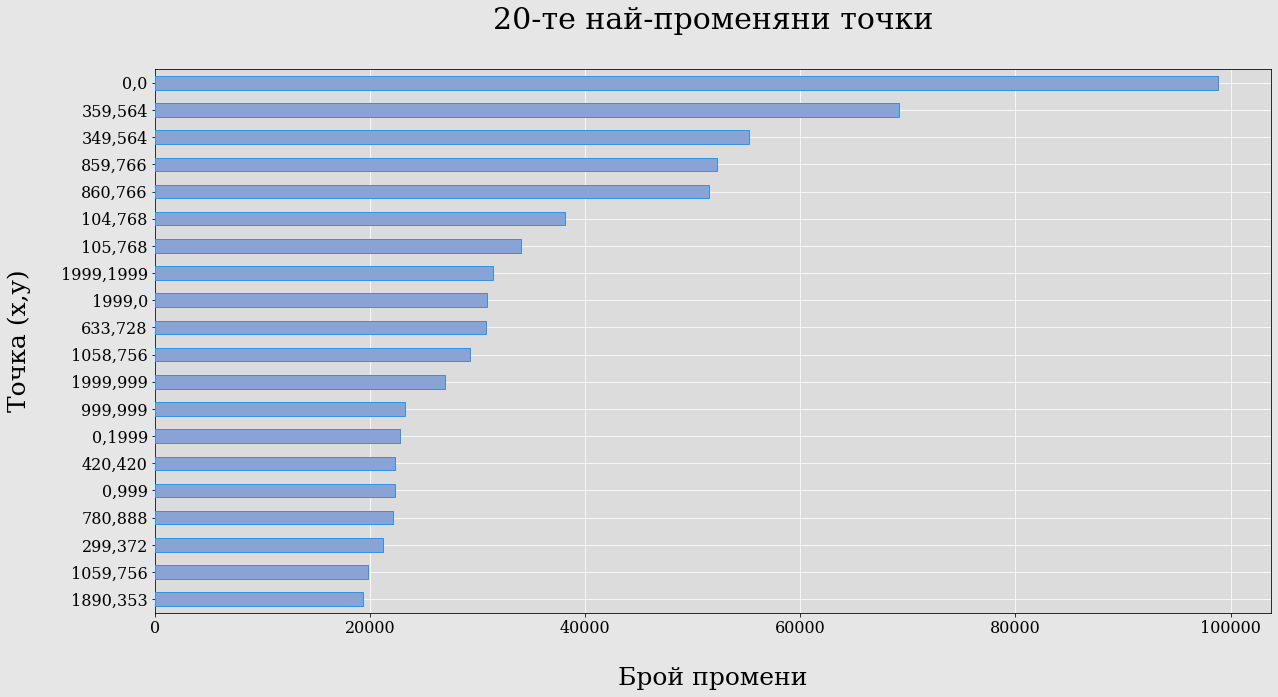

In [30]:
plot = top_active_spots.plot(kind='barh', zorder=3,  edgecolor='#3193E4')

plot.set_title('20-те най-променяни точки')
plot.set_xlabel('Брой промени')
plot.set_ylabel('Точка (x,y)')

plot.invert_yaxis()

In [31]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\plot_coordinates-{now}.png')

### Кръгови диаграми и таблица, показващи броя пъти, през които е било нужно цензуриране

In [32]:
ddf_moderated = ddf_main.copy()
ddf_moderated['comma_count'] = ddf_moderated.coordinate.str.count(',')

ddf_moderated.head()

,timestamp,pixel_color,coordinate,comma_count
97731,0,#7EED56,"42,42",1
97732,12356,#00A368,"999,999",1
97733,16311,#3690EA,"44,42",1
97734,21388,#D4D7D9,"2,2",1
97735,34094,#3690EA,"23,23",1


In [33]:
ddf_moderated = ddf_moderated[ddf_moderated['comma_count'] > 1]
ddf_moderated = ddf_moderated.drop('comma_count', axis=1)
ddf_moderated['timestamp'] = ddf_moderated.apply(lambda x: parse_timestamp(x['timestamp'], '%Y-%m-%d %H%M%S'), axis=1)

ddf_moderated = ddf_moderated.compute()
ddf_moderated = ddf_moderated.set_index('timestamp').reset_index()
 
ddf_moderated.head()

,timestamp,pixel_color,coordinate
0,2022-04-01 14:44:07,#898D90,"862,540,868,544"
1,2022-04-01 14:46:23,#898D90,"862,540,873,545"
2,2022-04-01 14:46:39,#898D90,"871,546,878,550"
3,2022-04-03 23:03:29,#FFB470,"298,1770,334,1803"
4,2022-04-03 23:05:04,#FFB470,"298,1805,329,1839"


In [34]:
ddf_moderated['coordinate'] = ddf_moderated['coordinate'].apply(lambda x: x.split(','))

ddf_moderated['x1'] = ddf_moderated['coordinate'].apply(lambda x: x[0]).astype('uint16')
ddf_moderated['y1'] = ddf_moderated['coordinate'].apply(lambda x: x[1]).astype('uint16')
ddf_moderated['x2'] = ddf_moderated['coordinate'].apply(lambda x: x[2]).astype('uint16')
ddf_moderated['y2'] = ddf_moderated['coordinate'].apply(lambda x: x[3]).astype('uint16')

ddf_moderated = ddf_moderated.drop('coordinate', axis=1)

ddf_moderated['num_pixels'] = (ddf_moderated['x2'] - ddf_moderated['x1'] + 1) * (ddf_moderated['y2'] - ddf_moderated['y1'] + 1).astype('uint16')

ddf_moderated.head()

,timestamp,pixel_color,x1,y1,x2,y2,num_pixels
0,2022-04-01 14:44:07,#898D90,862,540,868,544,35
1,2022-04-01 14:46:23,#898D90,862,540,873,545,72
2,2022-04-01 14:46:39,#898D90,871,546,878,550,40
3,2022-04-03 23:03:29,#FFB470,298,1770,334,1803,1258
4,2022-04-03 23:05:04,#FFB470,298,1805,329,1839,1120


In [35]:
moderated_count = ddf_moderated['pixel_color'].value_counts()

moderated_count.head()

#898D90    4
#FFB470    4
#000000    4
#FFF8B8    2
#94B3FF    2
Name: pixel_color, dtype: int64

In [36]:
num_moderated_pixels = ddf_moderated.groupby('pixel_color').num_pixels.sum().astype('int32')

num_moderated_pixels.head(10)

pixel_color
#000000    85584
#00CC78      910
#2450A4     1739
#898D90     1827
#94B3FF      436
#B44AC0     2250
#FFB470     8530
#FFF8B8     1018
Name: num_pixels, dtype: int32

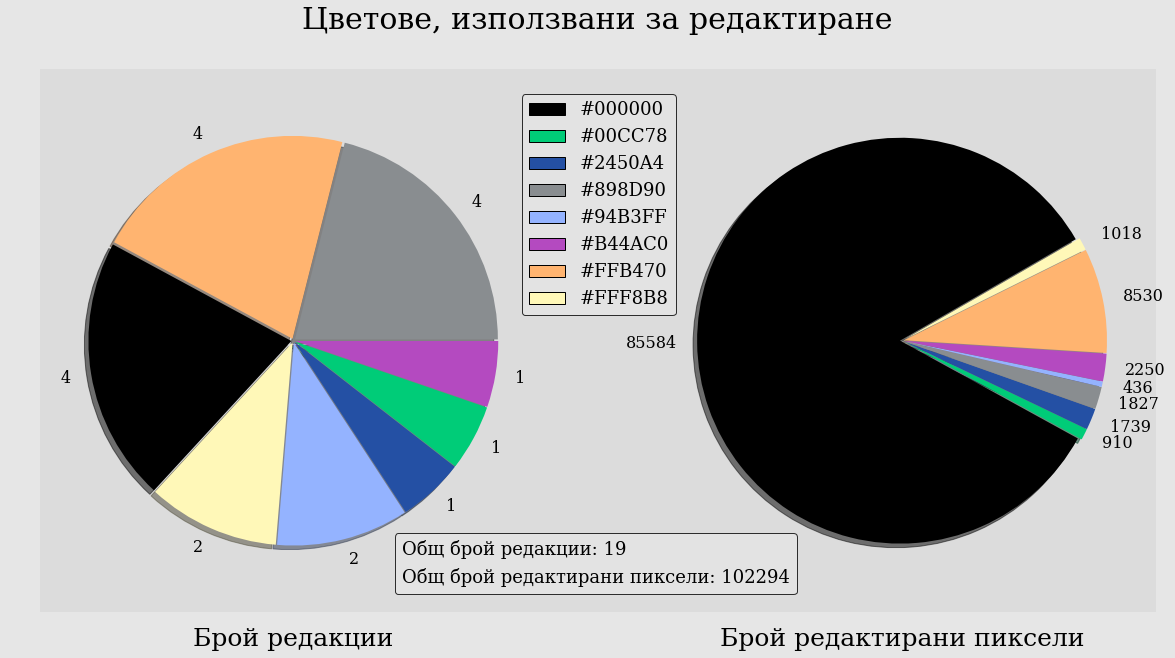

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)    
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='#E6E6E6', top=False, bottom=False, left=False, right=False)
ax.grid(False)

ax.set_title('Цветове, използвани за редактиране')

color_pie = []
for color_num in moderated_count.iteritems():
    color_pie.append(color_num[0])

labels_pie = []
for count in moderated_count.iteritems():
    labels_pie.append(count[1])

explode_pie = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

moderated_count.plot(kind='pie', colors=color_pie, labels=labels_pie, explode=explode_pie, ax=ax1, shadow=True)

ax1.set_xlabel('Брой редакции')
ax1.set_ylabel('')

color_pie = []
for color_num in num_moderated_pixels.iteritems():
    color_pie.append(color_num[0])

labels_pie = []
for count in num_moderated_pixels.iteritems():
    labels_pie.append(count[1])

num_moderated_pixels.plot(kind='pie', colors=color_pie, labels=labels_pie, explode=explode_pie, ax=ax2, startangle=30, shadow=True)

ax2.set_xlabel('Брой редактирани пиксели')
ax2.set_ylabel('')

leg = ax1.legend(labels=color_pie, loc=(0.95,0.55), prop={'size' : 18}, facecolor='#E6E6E6', edgecolor='black')
for i in range(0,len(color_pie)):
    leg.legendHandles[i].set_color(color_pie[i]) 
    leg.legendHandles[i].set_edgecolor('black')

custom_text = [f'Общ брой редакции: {moderated_count.sum()}', f'Общ брой редактирани пиксели: {num_moderated_pixels.sum()}']
custom_label = ax2.legend(labels=custom_text, loc=(-0.5,0), handlelength=0, handletextpad=0, fancybox=True, prop=dict(size=18), facecolor='#E6E6E6', edgecolor='black')
for item in custom_label.legendHandles:
    item.set_visible(False)

In [38]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig.savefig(f'output\\plot_moderated-{now}.png')

### Таблица с информация за всяка редакция от администратори

In [39]:
ddf_moderated['Цвят'] = ddf_moderated['pixel_color']
ddf_moderated = ddf_moderated.rename(columns={'timestamp': 'Дата и час (UTC)', 'pixel_color': 'Цвят (hex)', 'num_pixels': 'Брой пиксели'})
ddf_moderated = ddf_moderated[['Дата и час (UTC)', 'Цвят (hex)', 'Цвят', 'x1', 'y1', 'x2', 'y2', 'Брой пиксели']]

ddf_moderated.head()

,Дата и час (UTC),Цвят (hex),Цвят,x1,y1,x2,y2,Брой пиксели
0,2022-04-01 14:44:07,#898D90,#898D90,862,540,868,544,35
1,2022-04-01 14:46:23,#898D90,#898D90,862,540,873,545,72
2,2022-04-01 14:46:39,#898D90,#898D90,871,546,878,550,40
3,2022-04-03 23:03:29,#FFB470,#FFB470,298,1770,334,1803,1258
4,2022-04-03 23:05:04,#FFB470,#FFB470,298,1805,329,1839,1120


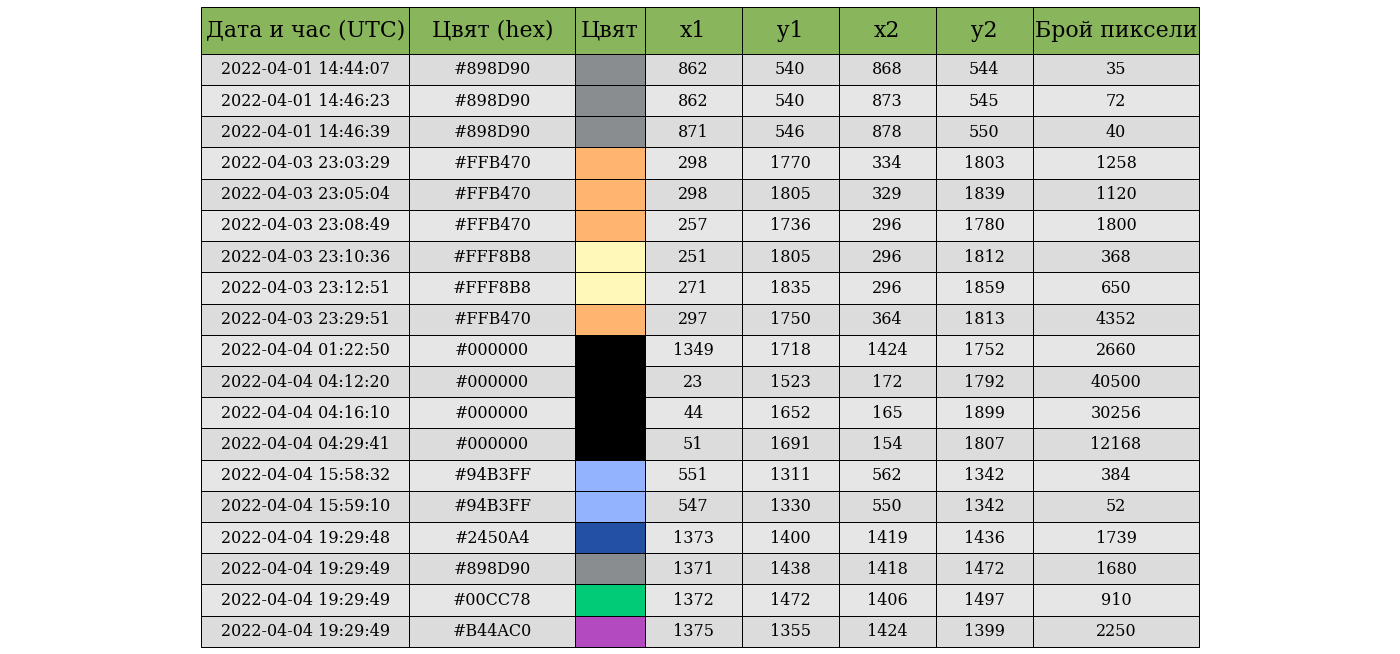

In [40]:
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

col_widths = []
for col in range(0,len(ddf_moderated.columns)):
    if (col == 0):
        col_widths.append(0.15)
    elif (col == 2):
        col_widths.append(0.05)
    elif (col == 1 or col == 7):
        col_widths.append(0.12)
    else:
        col_widths.append(0.07)


table = ax.table(cellText=ddf_moderated.values, colLabels=ddf_moderated.columns, loc='center', colWidths=col_widths, cellLoc='center')
table.scale(1,3)
table.auto_set_font_size(False)
table.set_fontsize(16)

for (row, col), cell in table.get_celld().items():
    if (row % 2 == 0):
        cell.set_facecolor('#E6E6E6')
    else:
        cell.set_facecolor('#DCDCDC')

    if (row == 0):
        cell.set_facecolor('#89B55C')
        cell.set_text_props(fontproperties=FontProperties(size=22))
        cell.set_height(0.1)
    elif (col == 2):
        cell.set_facecolor(cell._text.get_text())
        cell.get_text().set_text('')   

fig.tight_layout()

In [41]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig.savefig(f'output\\table_moderated-{now}.png')

### Диаграма, показваща броя поставени пиксели за всеки час

In [42]:
ddf_datecount = ddf_datecount.set_index('datetime')
ddf_datecount = ddf_datecount.compute()

ddf_datecount.head()

,num_pixels
datetime,
2022-04-01 12:00:00,19
2022-04-01 13:00:00,548836
2022-04-01 14:00:00,867847
2022-04-01 15:00:00,996924
2022-04-01 16:00:00,1070919


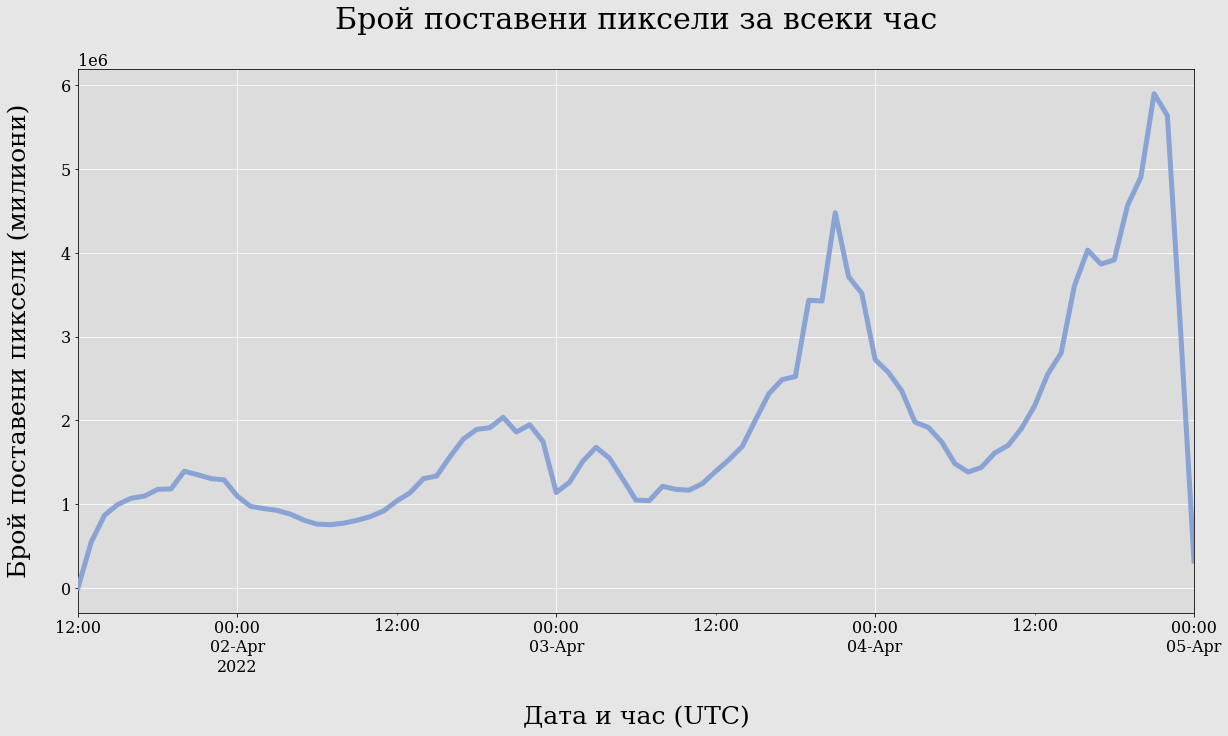

In [43]:
plot = ddf_datecount.plot(kind='line', zorder=3, linewidth=5)

plot.set_title('Брой поставени пиксели за всеки час')
plot.set_xlabel('Дата и час (UTC)')
plot.set_ylabel('Брой поставени пиксели (милиони)')

plot.get_legend().remove()

In [44]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\activity-{now}.png')

### Диаграма, показваща кумулативния брой поставени пиксели

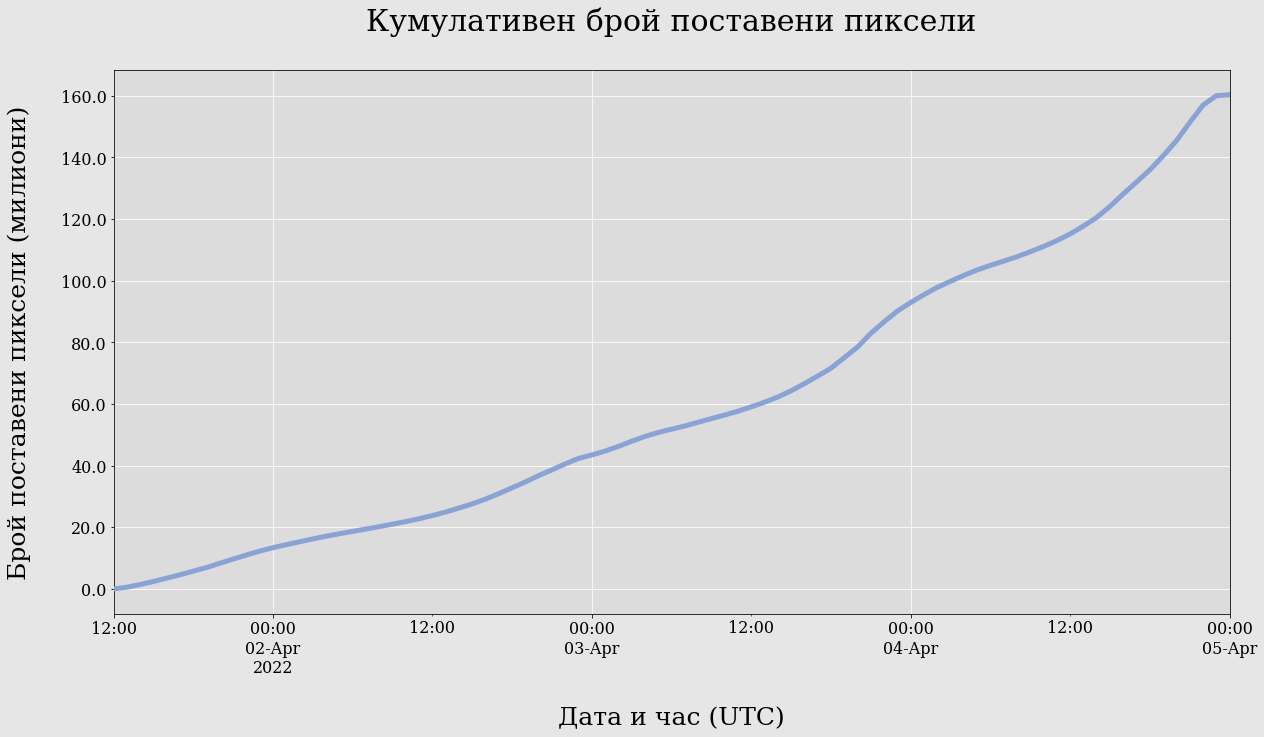

In [45]:
plot = ddf_datecount.cumsum().plot(kind='line', zorder=3, linewidth=5)

plot.set_title('Кумулативен брой поставени пиксели')
plot.set_xlabel('Дата и час (UTC)')
plot.set_ylabel('Брой поставени пиксели (милиони)')

formatter = FuncFormatter(millions)
plot.yaxis.set_major_formatter(formatter)

plot.get_legend().remove()

In [46]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\activity-cumsum-{now}.png')

# Анимирани диаграми

In [14]:
period_format = '%H:%M %d-%m-%Y'

bars_cmap = [
        '#000000', 
        '#00A368', 
        '#2450A4', 
        '#3690EA', 
        '#51E9F4', 
        '#7EED56', 
        '#811E9F', 
        '#898D90', 
        '#9C6926', 
        '#B44AC0', 
        '#D4D7D9', 
        '#FF4500', 
        '#FF99AA', 
        '#FFA800', 
        '#FFD635', 
        '#FFFFFF', 
        '#00756F', 
        '#009EAA', 
        '#00CC78', 
        '#493AC1', 
        '#6A5CFF', 
        '#6D482F', 
        '#BE0039', 
        '#FF3881', 
        '#00CCC0', 
        '#515252', 
        '#6D001A', 
        '#94B3FF', 
        '#DE107F', 
        '#E4ABFF', 
        '#FFB470', 
        '#FFF8B8'
]

fixed_bars_cmap = [
        '#000000', 
        '#FFFFFF', 
        '#FF4500', 
        '#2450A4', 
        '#FFD635', 
        '#BE0039', 
        '#51E9F4', 
        '#811E9F', 
        '#FFA800', 
        '#FF99AA', 
        '#3690EA', 
        '#00A368', 
        '#898D90', 
        '#7EED56', 
        '#D4D7D9', 
        '#9C6926', 
        '#FFB470', 
        '#FF3881', 
        '#B44AC0', 
        '#6D482F', 
        '#00CC78', 
        '#493AC1', 
        '#FFF8B8', 
        '#515252', 
        '#6D001A', 
        '#DE107F', 
        '#00756F', 
        '#6A5CFF', 
        '#94B3FF', 
        '#009EAA', 
        '#E4ABFF', 
        '#00CCC0'
]

### Диаграма, показваща броя поставени пиксели за всеки час

In [48]:
# Анимирана диаграма

#if SAVE_FILES:
#    fig = plt.figure()
#    ax = plt.axes()
#
#    ax.set_title('Брой поставени пиксели за всеки час')
#    ax.set_xlabel('Дата и час (UTC)')
#    ax.set_ylabel('Брой поставени пиксели (милиони)')
#
#    now = datetime.now().strftime('%d%H%M')
#
#    ddf_datecount.plot_animated(filename=f'output\\temp\\animated_activity-{now}.gif', 
#        fig=fig, 
#        add_legend=False, 
#        kind='line', 
#        linewidth=5,
#        figsize=(25,10),
#        period_fmt=period_format,
#        period_label=False,
#        tick_label_size=16,
#        label_events={    
#            '  Първи ден': datetime.strptime('00:00 01-04-2022', period_format),
#            '  Втори ден': datetime.strptime('00:00 02-04-2022', period_format),
#            '  Трети ден': datetime.strptime('00:00 03-04-2022', period_format),
#            '  Четвърти ден': datetime.strptime('00:00 04-04-2022', period_format)
#        },
#        antialiased=True,
#        )
#
#    clip = mp.VideoFileClip(f'output\\temp\\animated_activity-{now}.gif')
#    clip.write_videofile(f'output\\animated_activity-{now}.mp4', fps=60)

### Диаграма, показваща кумулативния брой поставени пиксели

In [49]:
# Анимирана диаграма

#if SAVE_FILES:
#    fig = plt.figure()
#    ax = plt.axes()
#
#    ax.set_title('Кумулативен брой поставени пиксели')
#    ax.set_xlabel('Дата и час (UTC)')
#    ax.set_ylabel('Брой поставени пиксели (милиони)')
#
#    now = datetime.now().strftime('%d%H%M')
#
#    ddf_datecount.cumsum().plot_animated(filename=f'output\\temp\\animated_activity_cumsum-{now}.gif', 
#        fig=fig, 
#        add_legend=False, 
#        kind='line', 
#        figsize=(25,10),
#        period_fmt=period_format,
#        period_label=False,
#        tick_label_size=16,
#        label_events={    
#            '  Първи ден': datetime.strptime('00:00 01-04-2022', period_format),
#            '  Втори ден': datetime.strptime('00:00 02-04-2022', period_format),
#            '  Трети ден': datetime.strptime('00:00 03-04-2022', period_format),
#            '  Четвърти ден': datetime.strptime('00:00 04-04-2022', period_format)
#        },
#        fill_under_line_color='#89A3D5',
#        antialiased=True
#        )
#
#    clip = mp.VideoFileClip(f'output\\temp\\animated_activity_cumsum-{now}.gif')
#    clip.write_videofile(f'output\\animated_activity_cumsum-{now}.mp4', fps=60)

### Анимирана графика, показваща броя и вида поставевни цветове за всеки час

In [12]:
ddf_pivoted = ddf_pivoted.compute()

In [51]:
if SAVE_FILES:
    fig = plt.figure()
    ax = plt.axes()

    ax.set_title('Брой поставени пиксели според цвета за всеки час')
    ax.set_ylabel('Цвят (hex)')
    ax.set_xlabel('Брой пиксели')

    now = datetime.now().strftime('%d%H%M')

    ddf_pivoted.plot_animated(filename=f'output\\temp\\animated_colors-{now}.gif',    
        period_length=400,
        bar_label_size=14,
        add_legend=False, 
        figsize=(25,10),
        fig=fig,
        period_fmt=period_format,
        fixed_order=fixed_bars_cmap,
        period_label=True,
        tick_label_size=14,
        cmap=fixed_bars_cmap,
        antialiased=True,
        fixed_max=True,
        )

    clip = mp.VideoFileClip(f'output\\temp\\animated_colors-{now}.gif')
    clip.write_videofile(f'output\\animated_colors-{now}.mp4', fps=60)

Generating BarChartRace, plotting ['#000000', '#FFFFFF', '#FF4500', '#2450A4', '#FFD635', '#BE0039', '#51E9F4', '#811E9F', '#FFA800', '#FF99AA', '#3690EA', '#00A368', '#898D90', '#7EED56', '#D4D7D9', '#9C6926', '#FFB470', '#FF3881', '#B44AC0', '#6D482F', '#00CC78', '#493AC1', '#FFF8B8', '#515252', '#6D001A', '#DE107F', '#00756F', '#6A5CFF', '#94B3FF', '#009EAA', '#E4ABFF', '#00CCC0']
Moviepy - Building video output\animated_colors-201551.mp4.
Moviepy - Writing video output\animated_colors-201551.mp4



Moviepy - Done !
Moviepy - video ready output\animated_colors-201551.mp4


### Анимирана графика, показваща кумумулативния брой поставени пиксели от всеки цвят

In [18]:
if SAVE_FILES:
    plt.rcParams['xtick.labelsize'] = 0

    fig = plt.Figure()
    gs = plt.GridSpec(1,2, width_ratios=[7,3])

    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])

    fig.suptitle('Кумулативен брой поставени пиксели от всеки цвят')
    ax1.set_ylabel('Цвят (hex)')
    ax1.set_xlabel('Брой пиксели (милиони)')

    formatter = FuncFormatter(millions)
    ax1.xaxis.set_major_formatter(formatter)

    now = datetime.now().strftime('%d%H%M')

    bar_chart = ddf_pivoted.cumsum().plot_animated(   
        period_length=300,
        bar_label_size=14,
        add_legend=False, 
        figsize=(25,10),
        period_fmt=period_format,
        period_label=True,
        tick_label_size=14,
        cmap=bars_cmap,
        antialiased=True,
        )

    bar_chart.ax = ax1

    pie_chart = ddf_pivoted.cumsum().plot_animated(  
        kind='pie',
        figsize=(10,10),
        cmap=bars_cmap,
        period_length=300
        )

    pie_chart.ax = ax2

    pandas_alive.animate_multiple_plots(f'output\\temp\\animated_colors_cumsum-{now}.gif', [bar_chart, pie_chart], fig)

    clip = mp.VideoFileClip(f'output\\temp\\animated_colors_cumsum-{now}.gif')
    clip.write_videofile(f'output\\animated_colors_cumsum-{now}.mp4', fps=60)

Generating BarChartRace, plotting ['#000000', '#00A368', '#2450A4', '#3690EA', '#51E9F4', '#7EED56', '#811E9F', '#898D90', '#9C6926', '#B44AC0', '#D4D7D9', '#FF4500', '#FF99AA', '#FFA800', '#FFD635', '#FFFFFF', '#00756F', '#009EAA', '#00CC78', '#493AC1', '#6A5CFF', '#6D482F', '#BE0039', '#FF3881', '#00CCC0', '#515252', '#6D001A', '#94B3FF', '#DE107F', '#E4ABFF', '#FFB470', '#FFF8B8']
Generating PieChart, plotting ['#000000', '#00A368', '#2450A4', '#3690EA', '#51E9F4', '#7EED56', '#811E9F', '#898D90', '#9C6926', '#B44AC0', '#D4D7D9', '#FF4500', '#FF99AA', '#FFA800', '#FFD635', '#FFFFFF', '#00756F', '#009EAA', '#00CC78', '#493AC1', '#6A5CFF', '#6D482F', '#BE0039', '#FF3881', '#00CCC0', '#515252', '#6D001A', '#94B3FF', '#DE107F', '#E4ABFF', '#FFB470', '#FFF8B8']
Moviepy - Building video output\animated_colors_cumsum-202221.mp4.
Moviepy - Writing video output\animated_colors_cumsum-202221.mp4



Moviepy - Done !
Moviepy - video ready output\animated_colors_cumsum-202221.mp4


In [53]:
plt.style.use('style.mplstyle')

### Анимирана графика, показваща броя поставени пиксели в 5-те най-популярни точки за всеки час

In [54]:
ddf_top_coords = ddf_main.copy()
ddf_top_coords = ddf_top_coords[
    (ddf_top_coords['coordinate'] == '0,0') | 
    (ddf_top_coords['coordinate'] == '359,564') | 
    (ddf_top_coords['coordinate'] == '349,564') | 
    (ddf_top_coords['coordinate'] == '859,766') | 
    (ddf_top_coords['coordinate'] == '860,766')
]
ddf_top_coords = ddf_top_coords.drop('pixel_color', axis=1)

ddf_top_coords.head()

,timestamp,coordinate
97741,169219,"0,0"
97790,1184423,"0,0"
97793,1184622,"0,0"
97889,1192817,"0,0"
98633,1221457,"0,0"


In [55]:
ddf_top_coords['index'] = ddf_top_coords.reset_index().index
ddf_top_coords['timestamp'] = ddf_top_coords.apply(lambda x: parse_timestamp(x['timestamp'], '%Y-%m-%d %H'), axis=1)
ddf_top_coords = ddf_top_coords.rename(columns={'timestamp': 'datetime'})

ddf_top_coords.head()

,datetime,coordinate,index
97741,2022-04-01 12:00:00,"0,0",0
97790,2022-04-01 13:00:00,"0,0",1
97793,2022-04-01 13:00:00,"0,0",2
97889,2022-04-01 13:00:00,"0,0",3
98633,2022-04-01 13:00:00,"0,0",4


In [56]:
ddf_top_coords['coordinate'] = ddf_top_coords['coordinate'].astype('category')
ddf_top_coords['coordinate'] = ddf_top_coords.coordinate.cat.as_known()

ddf_top_coords.dtypes

datetime      datetime64[ns]
coordinate          category
index                  int64
dtype: object

In [57]:
ddf_top_coords = ddf_top_coords.pivot_table(index='datetime', columns='coordinate', values='coordinate', aggfunc='count')
ddf_top_coords = ddf_top_coords.compute()

ddf_top_coords.head()

coordinate,"0,0","349,564","359,564","860,766","859,766"
datetime,,,,,
2022-04-01 12:00:00,1.0,0.0,0.0,0.0,0.0
2022-04-01 13:00:00,777.0,1.0,1.0,2.0,0.0
2022-04-01 14:00:00,705.0,0.0,0.0,670.0,751.0
2022-04-01 15:00:00,811.0,0.0,0.0,1635.0,1759.0
2022-04-01 16:00:00,1198.0,484.0,573.0,1598.0,1601.0


In [58]:
if SAVE_FILES:
    fig = plt.figure()
    ax = plt.axes()

    ax.set_title('Брой поставени пиксели за всеки час в 5-те най-популярни точки')
    ax.set_xlabel('Дата и час (UTC)')
    ax.set_ylabel('Брой пиксели')

    now = datetime.now().strftime('%d%H%M')

    ddf_top_coords.plot_animated(filename=f'output\\temp\\animated_top5_coords-{now}.gif', 
        fig=fig, 
        add_legend=True, 
        linewidth=5,
        kind='line', 
        figsize=(25,10),
        period_fmt=period_format,
        period_label=False,
        tick_label_size=16,
        label_events={    
            '  Първи ден': datetime.strptime('00:00 01-04-2022', period_format),
            '  Втори ден': datetime.strptime('00:00 02-04-2022', period_format),
            '  Трети ден': datetime.strptime('00:00 03-04-2022', period_format),
            '  Четвърти ден': datetime.strptime('00:00 04-04-2022', period_format)
        },
        antialiased=True,
        period_length=300
        )

    clip = mp.VideoFileClip(f'output\\temp\\animated_top5_coords-{now}.gif')
    clip.write_videofile(f'output\\animated_top5_coords-{now}.mp4', fps=60)

Generating LineChart, plotting ['0,0', '349,564', '359,564', '860,766', '859,766']
Moviepy - Building video output\animated_top5_coords-201618.mp4.
Moviepy - Writing video output\animated_top5_coords-201618.mp4



Moviepy - Done !
Moviepy - video ready output\animated_top5_coords-201618.mp4
